# Comorbidome plot

## Introduction

This work is part of the results published in [our article](https://link.springer.com/article/10.1007/s13555-023-00986-0)

<i>Buja A, Miatton A, Cozzolino C, Brazzale AR, Lo Bue R, Mercuri SR, Proft FN, Kridin K, Cohen AD, Damiani G. The Prevalent Comorbidome at the Onset of Psoriasis Diagnosis. Dermatol Ther (Heidelb). 2023 Sep;13(9):2093-2105. doi: 10.1007/s13555-023-00986-0. Epub 2023 Aug 5.</i>

If you enjoy this project, you are welcome to cite our article and sustain my GitHub profile leaving a ⭐!

Thank you ❤️,

<br>

<i>Claudia Cozzolino </i>

For any enquiry contact claudia.cozzolino@studenti.unipd.it or on [LinkedIn](https://www.linkedin.com/in/claudia-cozzolino-7b11661b8/)

## Aim

The aim of this code is to obtain a graphical representation of commonly used clinical statistics such as prevalences and odd rations (ORs) is the form of a <i> comorbidome plot</i>.

In our article, the prevalence rates for each pre-existing morbidity were calculated as percentages. Univariate logistic regression was insted performed to assess the odds ratio (OR) for each comorbidity in psoriatic subjects compared with non-psoriatic subjects. Results were considered statistically significant at $0.001$, which takes into account the multiple tests performed.

The comorbidome plot graphically represents all comorbidities that had a statistically significant association with psoriasis onset ($p < 0.001$). The size of each bubble is proportional to the prevalence of the disease in the psoriatic cohort, while proximity to the center (psoriasis) expresses the strength of the association between the comorbidity and psoriasis diagnosis (this was numerically obtained as the inverse of the OR, $1/OR$). All circles relating to a disease with an increased occurrence in the psoriatic group fall inside the dashed orbit ($1/OR < 1$), while morbidities with a decreased prevalence are outside ($1/OR > 1$).


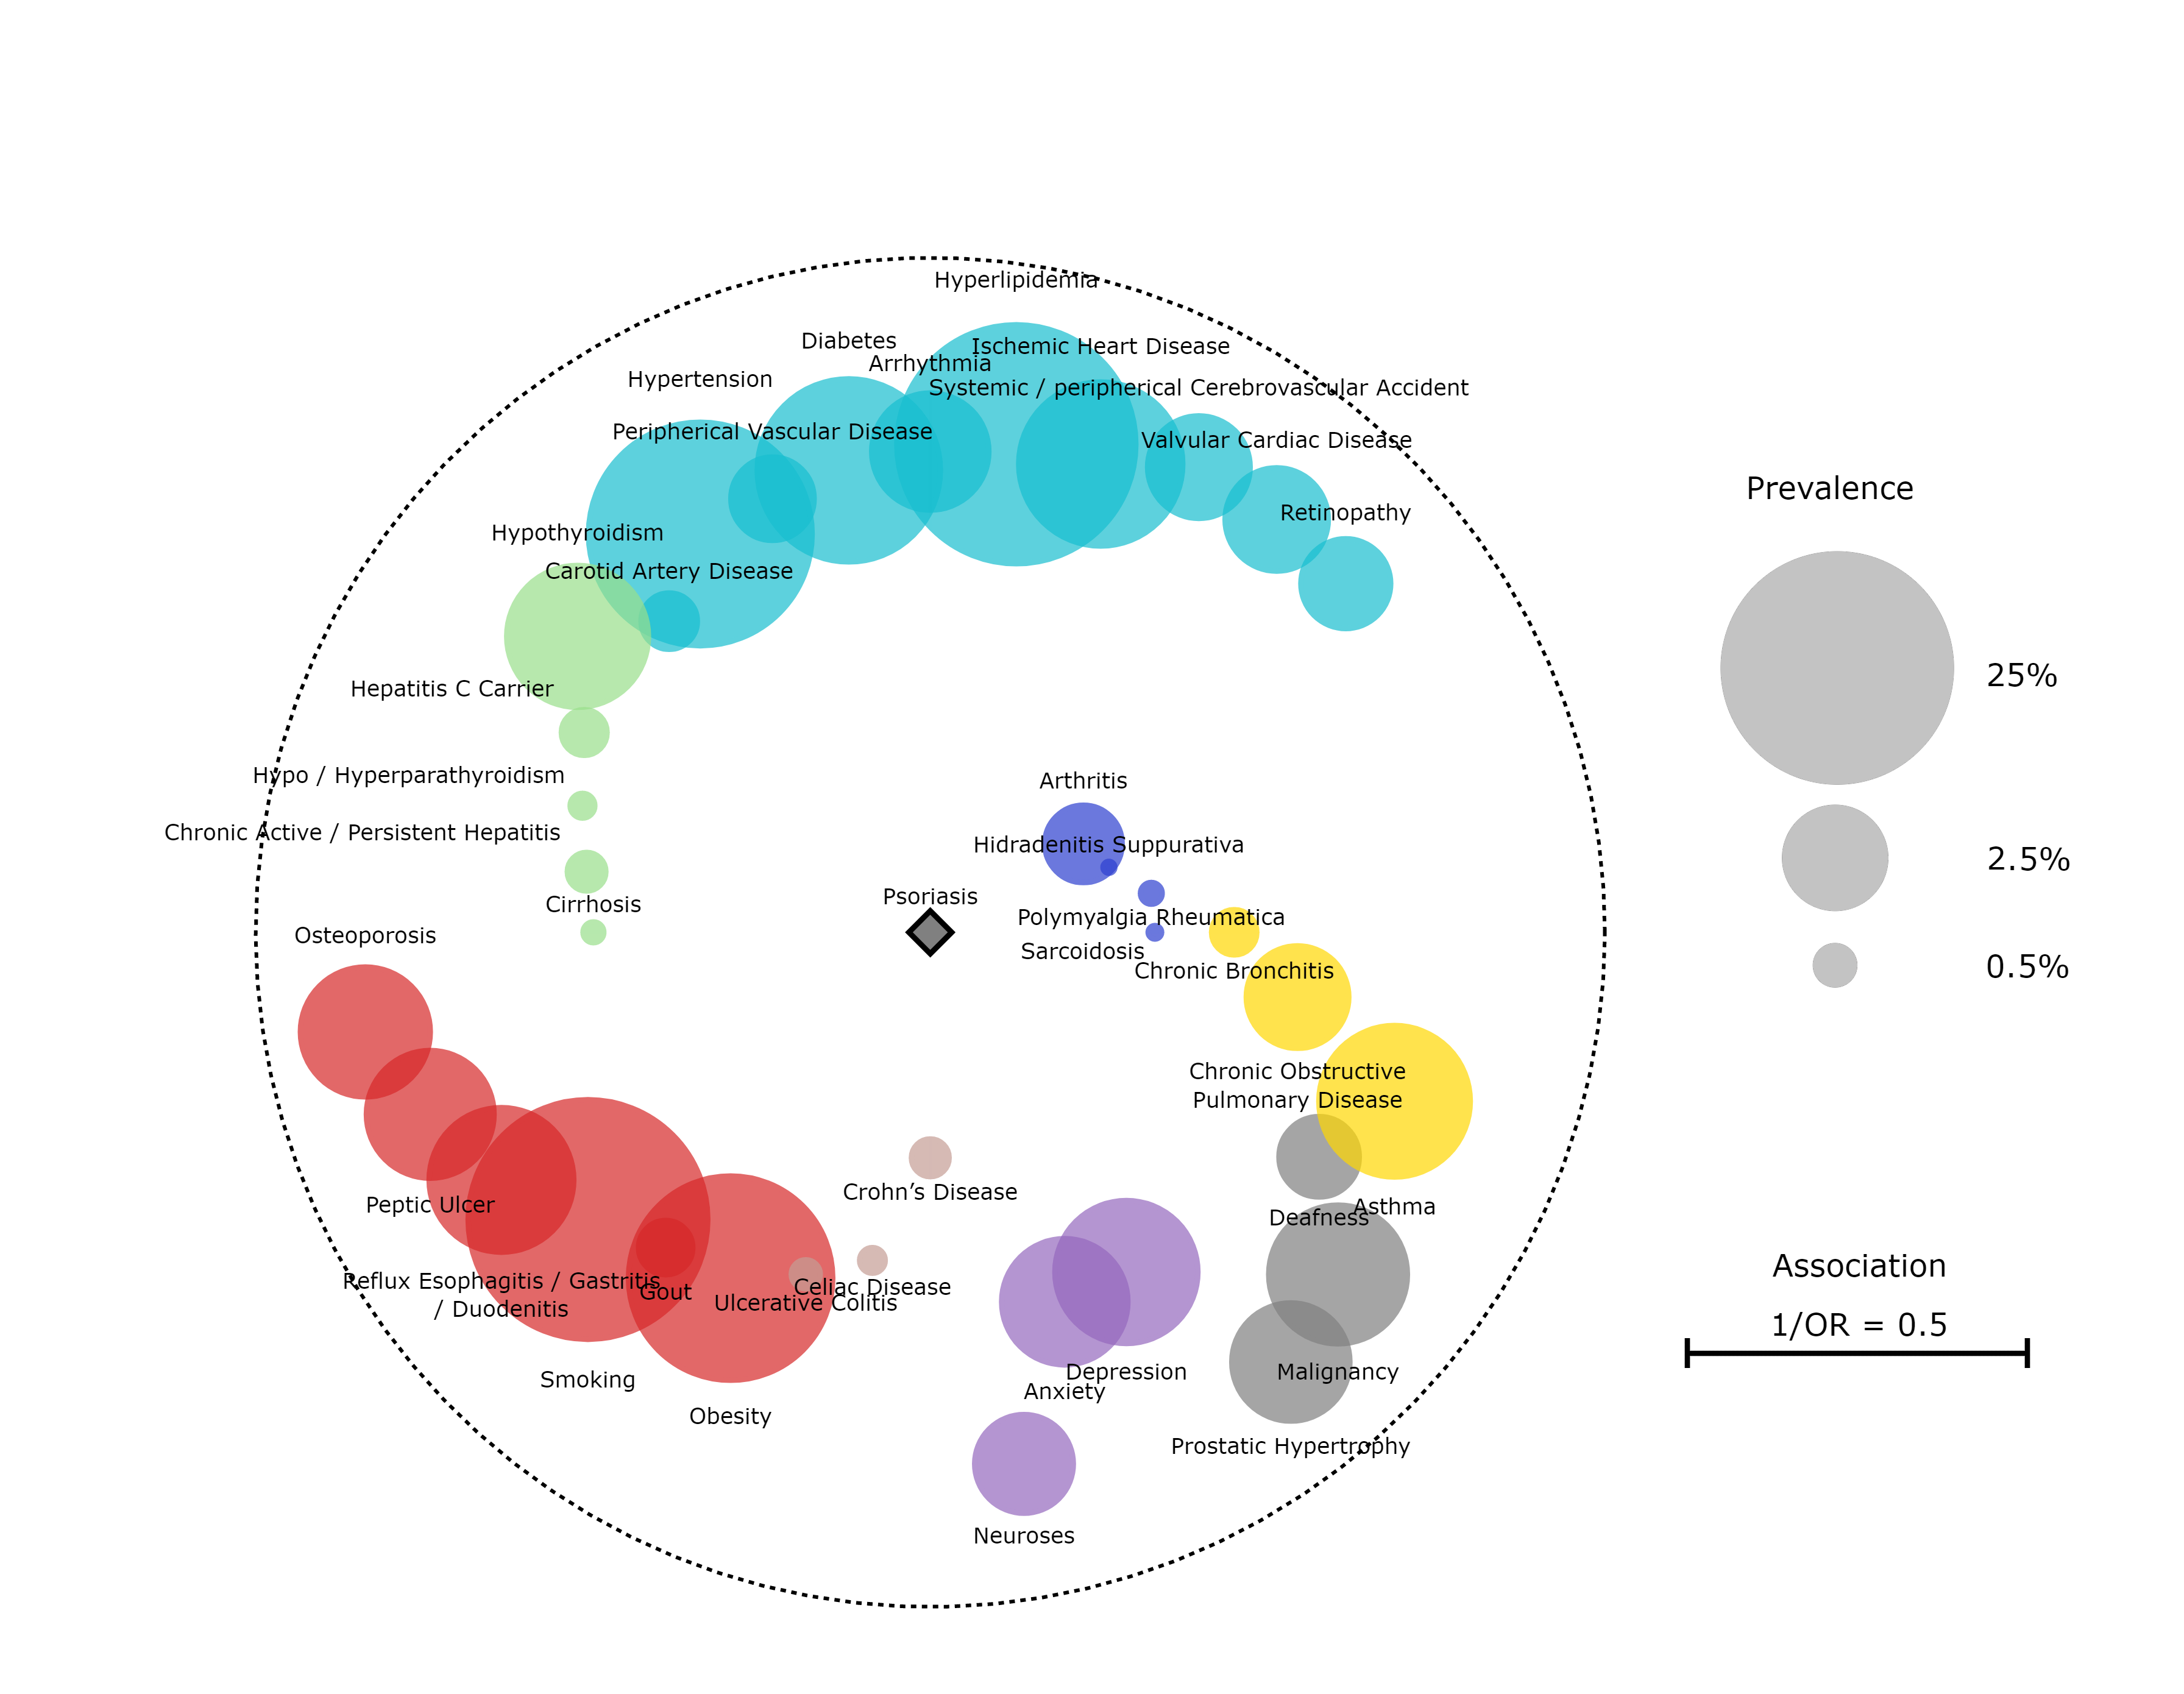

## Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly

## Data

The code presented below does not include the calculation of prevalence and odd ratios.
The datasheet to obtain the comorbidome plot from this script has one row for each comorbidity and the following mandatory variables:
- ```comorbidity_html_name```: the clean name of each comorbidity eventually formatted with HTML tags style
- ```perc```: prevalence percentage ($\in [0, 1]$) of each comorbidity in the case group (here psoriatic subjects)
- ```OR_ref_control```: logistic regression OR of association with condition or health outcome defining a case (here psoriasis) for each comorbidity. 
- ```signif```: boolen variable defining whether the OR p-value is below the level of significance (here ```True``` if $p<0.001$).

Additionally, a grouping variable ```group``` could be defined to personalize color scheme according to a certain criterion (here disease macro-classification).



 

In [2]:
data = pd.read_excel('example_data_pso.xlsx') # load data
data = data.loc[data.include_results == 'Yes'] # filter only pre selected rows

In [3]:
data.head()

,Comorbidity,comorbidity_html_name,group,include_results,n,perc,OR_ref_control,p-value,signif
0,Hidradenitis Suppurativa_prev_pso,Hidradenitis Suppurativa,Autoimmune and inflammatory systemic diseases,Yes,39,0.136297,3.548929,2.078330e-04,True
1,Polymyalgia Rheumatica_prev_pso,Polymyalgia Rheumatica,Autoimmune and inflammatory systemic diseases,Yes,78,0.272594,3.005467,1.193768e-06,True
2,Rheumatoid Arthritis_prev_pso,Arthritis,Autoimmune and inflammatory systemic diseases,Yes,456,1.593625,3.813431,6.757174e-39,True
3,Sarcoidosis_prev_pso,Sarcoidosis,Autoimmune and inflammatory systemic diseases,Yes,45,0.157266,3.003150,2.269613e-04,True
4,Arrhythmia_prev_pso,Arrhythmia,Cardiovascular and metabolic diseases,Yes,1022,3.571678,1.402980,5.262036e-12,True


## Processing

1) Define a color scheme and ordering based on the groping variable. This step is not mandatory. When grouping variable in not defined symply assign:

    data['colore'] = 'red' # or your favourite color ;)
    data['ordine'] = 1

In [4]:
data['color'] = data.group.map({'Autoimmune and inflammatory systemic diseases':'#2b3ecf',  # match your groups with colors
'Cardiovascular and metabolic diseases':'#17becf',#aec7e8', 
'Endocrine diseases': '#98df8a',
'Environmental and lifestyle-related conditions':'#d62728',
'Hepatological disease': '#fc8a51',
'Inflammatory bowel diseases':'#c49c94',  ####
'Mental disorders':'#9467bd', 
'Other':'#7f7f7f',
'Pulmonary inflammatory diseases':'gold'})

data['order'] = data.group.map({'Autoimmune and inflammatory systemic diseases':1,  # match your groups with integers to order accordingly
'Cardiovascular and metabolic diseases':2, 
'Endocrine diseases': 4,
'Environmental and lifestyle-related conditions':5,
'Hepatological disease': 3,
'Inflammatory bowel diseases':7,
'Mental disorders':8,
'Other':9,
'Pulmonary inflammatory diseases':10})


2) Sort the data. This step is not mandatory, but it usually provides a nicer (helical) graphic arrangement of the bubbles. Alternatively, you can try random combinations until satisfied with

    data = data.sample(frac=1).reset_index(drop=True) # random shuffle


In [5]:
data.sort_values(by = ['order', 'OR_ref_control','comorbidity_html_name'], inplace = True) # sort


3) Define bubbles shape. Here bubbles are defined as circles, but feel free to experiment with other marker types (see [here](https://plotly.com/python/marker-style/)). In addition, in the comorbidome plot bubbles will be filled when the OR p-values fall under the significance level, empty otherwise. Note that in our example, all p were below our defined threshold, $0.001$. Change appropriatelly the level according to your sample sizes.

In [6]:
data['signif_shape'] = data.signif.map({False: 'circle-open', True: 'circle'})

4) Define the position of the bubbles and their text annotation: from the polar co-ordinates to Cartesian co-ordinates, using the equations 

$x = r cosθ , y = r sinθ$

where $r_i = 1/OR_i$ and $θ_i =i2π/m$ for every comorbity $i$, $i$ from $1$ to $m$.

In [7]:
theta = np.linspace(0,2*np.pi,data.shape[0]) # sample m angles from 0 to 2 pi (in radiants), where m is the number of comorbidy bubbles
com_x = []
com_y = []
text_pos = []

for t,r_inv in zip(theta, data.OR_ref_control.values):
    com_x.append(np.cos(t)/r_inv)  # cartesian coords
    com_y.append(np.sin(t)/r_inv)
    
    # also define obtimal text position according to angle
    if t>=np.pi/20 and t<np.pi/17:    
        text_pos.append('bottom center')
    elif t>=np.pi/17 and t<3.5*np.pi/4:    
        text_pos.append('top center')
    elif t>=3.5*np.pi/4 and t<4*np.pi/4:    
        text_pos.append('top right')
    elif t>=4*np.pi/4 and t<5.1*np.pi/4:    
        text_pos.append('top center')
    elif t>=5.1*np.pi/4 and t<=8*np.pi/4:    
        text_pos.append('bottom center')

    else:
        text_pos.append('bottom left')
        
  
data['x'] = com_x
data['y'] = com_y
data['text_pos'] = text_pos

5) Define the orbit of radius $r = 1$.

In [8]:
theta = np.linspace(0,2*np.pi,1000) # angle in radiants

circ_x = [np.cos(t) for t in theta] # radius = 1
circ_y = [np.sin(t) for t in theta]


## Plot

Finally plot all the elements as Plotly Graphical Objects:

- central diamond representing the condition or health outcome under study (here psoriasis)
- orbit of radius $1$
- comorbidity bubbles.

In [ ]:
fig = go.Figure() # define empty figure

# add central diamond = studied condition or health outcome, here psoriasis
fig.add_trace(go.Scatter(x=[0], y=[0], mode = "markers+text", 
                         text=["Psoriasis"],                            # edit condition or health outcome text
                         textposition="top center", 
                         marker_symbol = 'diamond',                     # edit shape and color
                         marker_line_color="black", marker_color="gray", 
                         marker_line_width=3, marker_size=18, ))


# add orbit of radius = 1
fig.add_trace(go.Scatter(x=circ_x, y=circ_y,
                    mode='lines',
                    line=dict(color='black', width=2,  # edit line style
                              dash='dot')))


# add comorbidity bubbles
fig.add_trace(go.Scatter(x=data.x.values, y=data.y.values, mode = "markers+text", 
                         text=data.comorbidity_html_name.values , 
                         textposition=data.text_pos.values, 
                         marker_symbol = data.signif_shape.values, 
                         marker_line_color=data.color.values, 
                         marker_color=data.color.values,
                         marker_line_width=3, 
                         marker_size=24*np.log2(1.5*data.perc.values+1))) # scale arbitrarily

# edit general layout
fig.update_layout(
    width = 1000,
    height = 1000,
    title = "", # add title or note here
    showlegend=False,
    plot_bgcolor = 'rgba(0, 0, 0, 0)', #remove grid and background
    paper_bgcolor = 'rgba(0, 0, 0, 0)',
    xaxis = dict(                   #remove axis and ticks
            tickmode = 'array',
            tickvals = [],
            ticktext = []
        ),
    yaxis = dict(                   #remove axis and ticks
            tickmode = 'array',
            tickvals = [],
            ticktext = []
        ),
    font=dict(
            #family="Times New Roman",  # edit font family, color and size
            color="Black",
            size=12
        ),

)

fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )

# finally plot :)
fig.show()


# save your image
fig.write_image('comorbidome_plot.png', scale=3)         # static PNG image



## Notes

The graphical results obtainable with this code are partly data-dependent (number of bubbles and groups, OR values, etc.).
I recommend playing with the code until you get the most graphically pleasing result for you.
For example, 
- you can test other orders of comorbidities (step 2) until they the bubbles are evenly distributed in the figure 
- change the formula defining `marker_size` in terms of `data.perc` in the `go.Scatter` plot.
- filter out those with radius close to $0$ or $>>1$, e.g. with

    `data = data.loc[(np.abs(data.x)>10e-8) & (np.abs(data.y)>10e-8) & (np.abs(data.x)<1000) & (np.abs(data.y)<1000)] `
    
